# Tutorial

This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

Here, we use the `fitsio` package, just to read the test image, but you can also use `astropy.io.fits` for this purpose (or any other FITS reader).

In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

First, we'll read an example image from a FITS file and display it, just to show what we're dealing with. The example image is just 256 x 256 pixels.

In [3]:
# read image into standard 2-d numpy array
data = fitsio.read("../data/C17_driftscans/ffi-kacr2120/kplr2018131024020_ffi-orig.fits", ext=41)

Trim the edges off.

In [4]:
#data = data[50:600, 60:-60]
data = data[50:-50, 60:-60]

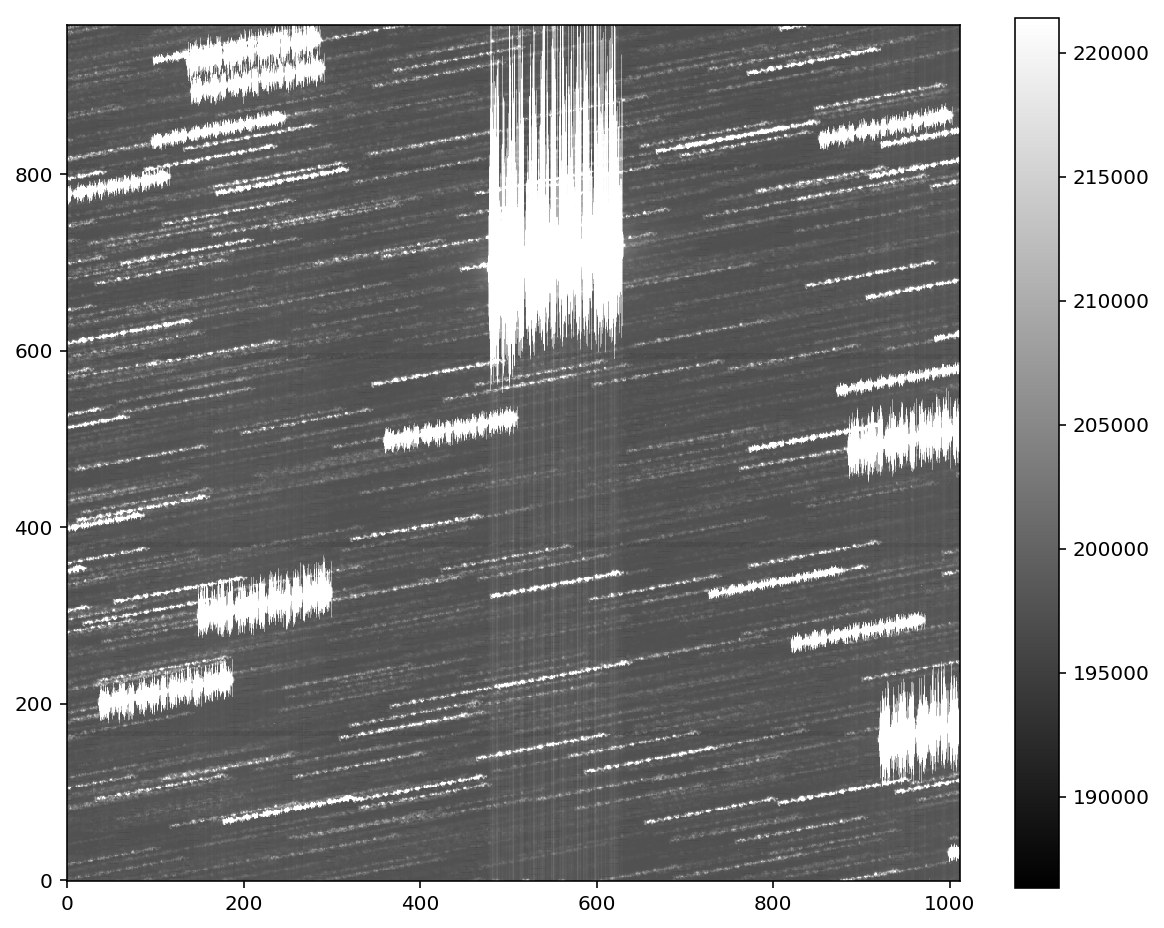

In [5]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

## Background subtraction

Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

Must use C order, h/t [StackOverflow](https://stackoverflow.com/questions/26778079/valueerror-ndarray-is-not-c-contiguous-in-cython).

In [6]:
data = data.copy(order='C')

In [7]:
mask = data > 210000

In [8]:
sy, sx = data.shape

In [9]:
# measure a spatially varying background on the image
bkg = sep.Background(data, mask=mask)

There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:
```python
bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)
```
See the reference section for descriptions of these parameters.

This returns an `Background` object that holds information on the spatially varying background and spatially varying background noise level.  We can now do various things with this `Background` object:

In [10]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

198089.5
584.4493408203125


In [11]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

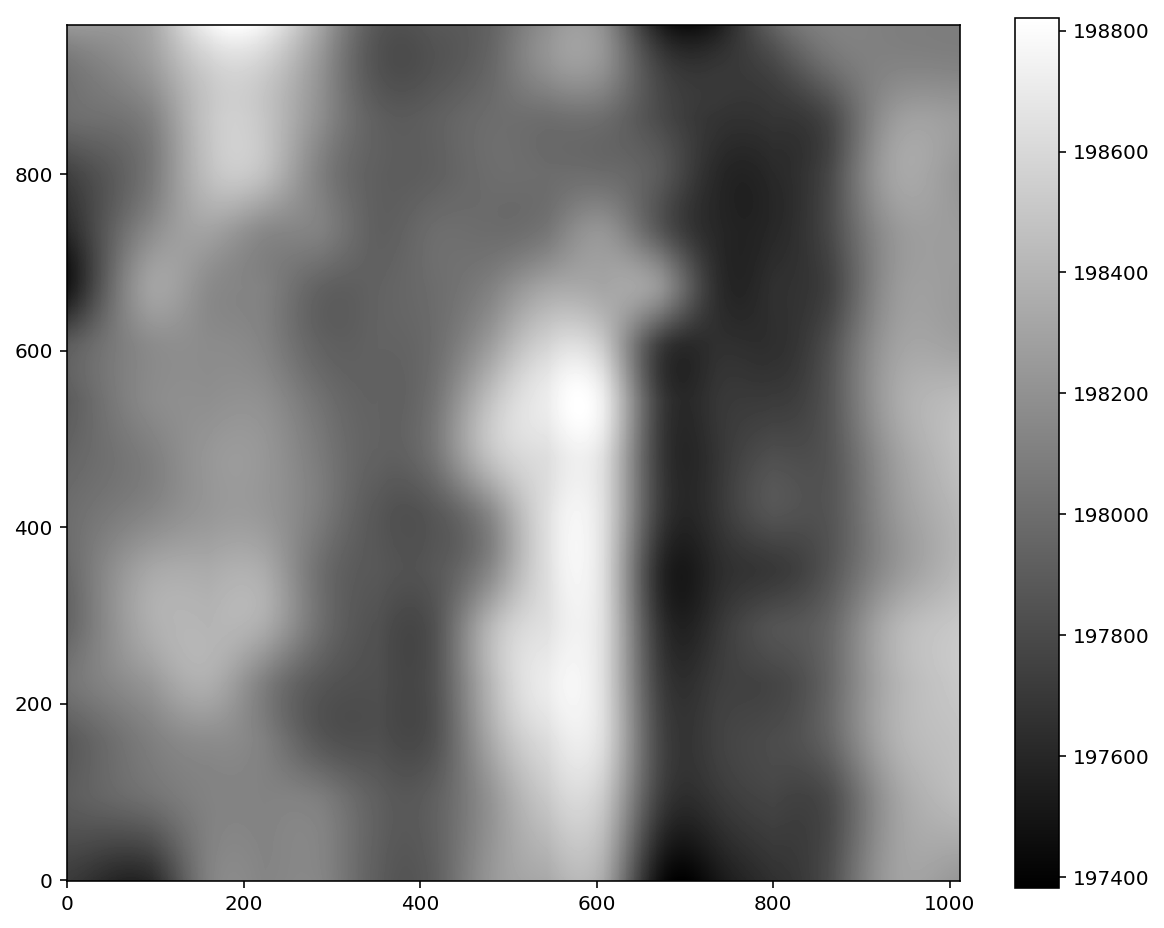

In [12]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [13]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

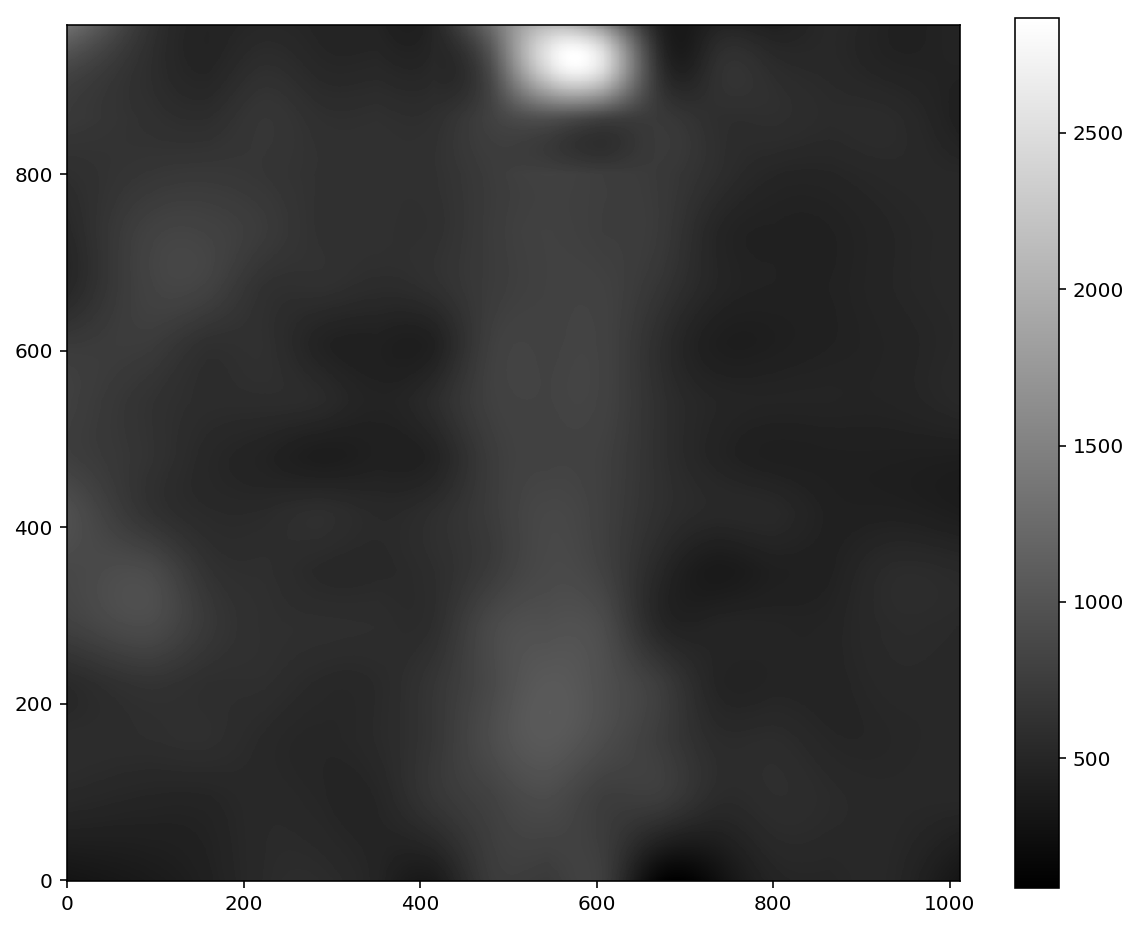

In [14]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [15]:
# subtract the background
data_sub = data - bkg

One can also subtract the background from the data array in-place by doing `bkg.subfrom(data)`.

<div class="alert alert-warning">

**Warning:**

If the data array is not background-subtracted or the threshold is too low, you will tend to get one giant object when you run object detection using `sep.extract`. Or, more likely, an exception will be raised due to exceeding the internal memory constraints of the `sep.extract` function.
</div>

## Object detection

Now that we've subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we're setting the detection threshold to be a constant value of $1.5 \sigma$ where $\sigma$ is the global background RMS.

In [16]:
kernel_raw = data_sub[250:310,810:985]

In [17]:
kernel_raw.shape

(60, 175)

In [18]:
kernel_raw = kernel_raw / np.percentile(kernel_raw, 95)
ny, nx = kernel_raw.shape
nx, ny

(175, 60)

In [19]:
kernel_x = kernel_raw.mean(axis=0)
kernel_y = kernel_raw.mean(axis=1)

Draw a line defined by the marginals.

In [20]:
x0, x1 = np.where(kernel_x/np.max(kernel_x) >0.5)[0][[0, -1]]
y0, y1 = np.where(kernel_y/np.max(kernel_y) >0.5)[0][[0, -1]]

In [21]:
line_vec_x, line_vec_y = np.arange(x0, x1), np.linspace(y0, y1, x1-x0)

In [22]:
kernel_mask = kernel_raw*0.0

for i,j in zip(line_vec_x, line_vec_y):
    kernel_mask[np.int(j), np.int(i)] = 1

Convolve the line with a 2 pixel Gaussian blur.

In [23]:
#from scipy.ndimage import gaussian_filter
#final_kernel = gaussian_filter(kernel_mask, 2)
final_kernel = np.load('ch41_FFI1_kernel.npy')

Save this nice kernel, just in case.

In [24]:
#np.save('ch41_FFI1_kernel.npy', final_kernel)

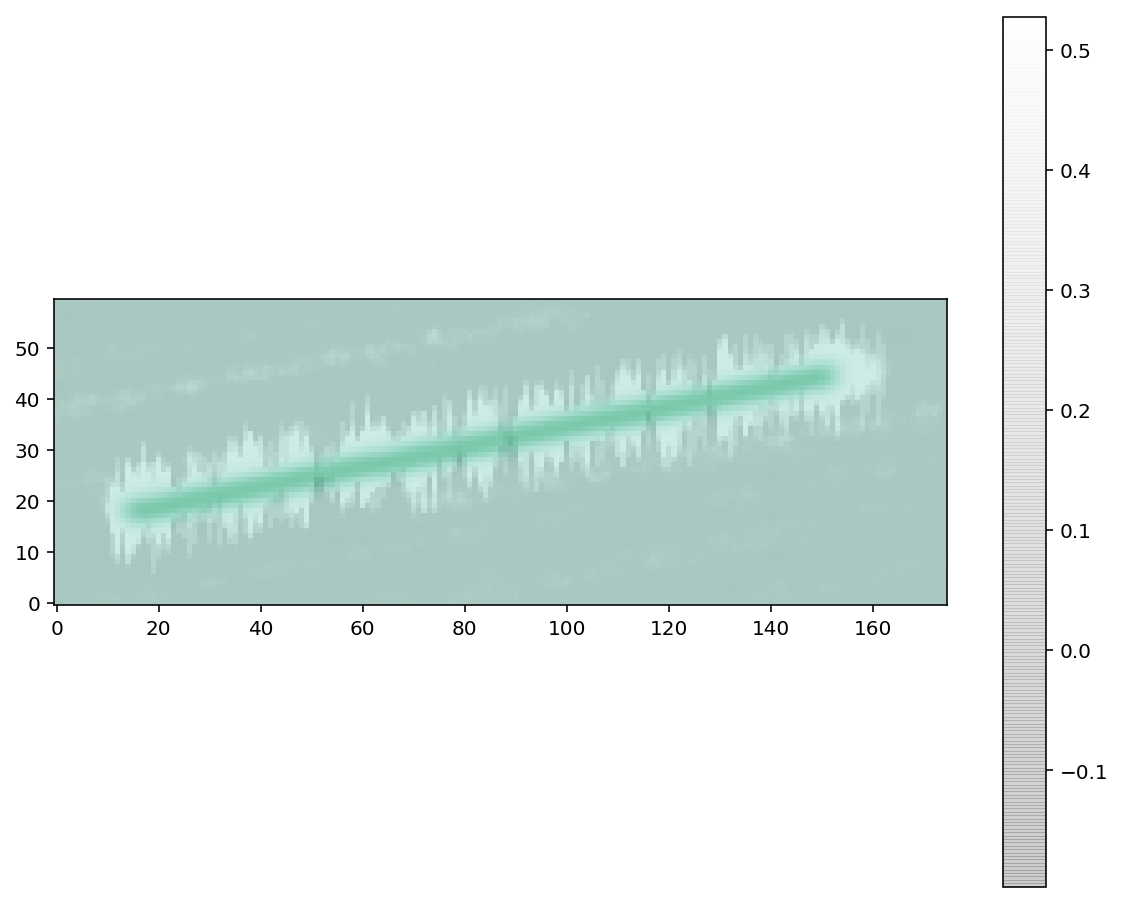

In [25]:
# show the image
m, s = np.mean(kernel_raw), np.std(kernel_raw)
plt.imshow(final_kernel, interpolation='nearest', cmap='BuGn', vmin=m-s, vmax=m+s, origin='lower')
plt.imshow(kernel_raw, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower', alpha=0.2)
plt.colorbar();

In [26]:
objects = sep.extract(data_sub, 4.0, filter_kernel=final_kernel,  err=bkg.globalrms, )

`sep.extract` has many options for controlling detection threshold, pixel masking, filtering, and object deblending. See the reference documentation for details.

`objects` is a NumPy structured array with many fields.

In [27]:
# how many objects were detected
len(objects)

77

`objects['x']` and `objects['y']` will give the centroid coordinates of the objects. Just to check where the detected objects are, we'll over-plot the object coordinates with some basic shape parameters on the image:

Hmm, some objects exhibit poor fits.  Let's filter the objects based on their metadata.
- Rotation angles should be close to 10 degrees.
- The semi-minor axes should be small; large semi-minor axes are indicative of saturated stars.

In [28]:
#plt.hist(objects['theta']* 180. / np.pi, bins=np.arange(0, 30, 1));
#plt.hist(objects['b'], bins=np.arange(0, 30, 1));

In [29]:
poor_fits = ( ((objects['theta']* 180. / np.pi) > 20) |
              (objects['b'] > 15.0) |
              (objects['x'] < (nx/2 + 2)) | 
              (objects['x'] > ( sx - nx/2 - 2)) |
              (objects['y'] < (ny/2 + 2)) |  
              (objects['y'] > ( sy - ny/2 - 2)) )

In [30]:
saturated_mask = (objects['b'] > 5.0) & ~poor_fits

In [31]:
from matplotlib.patches import Rectangle

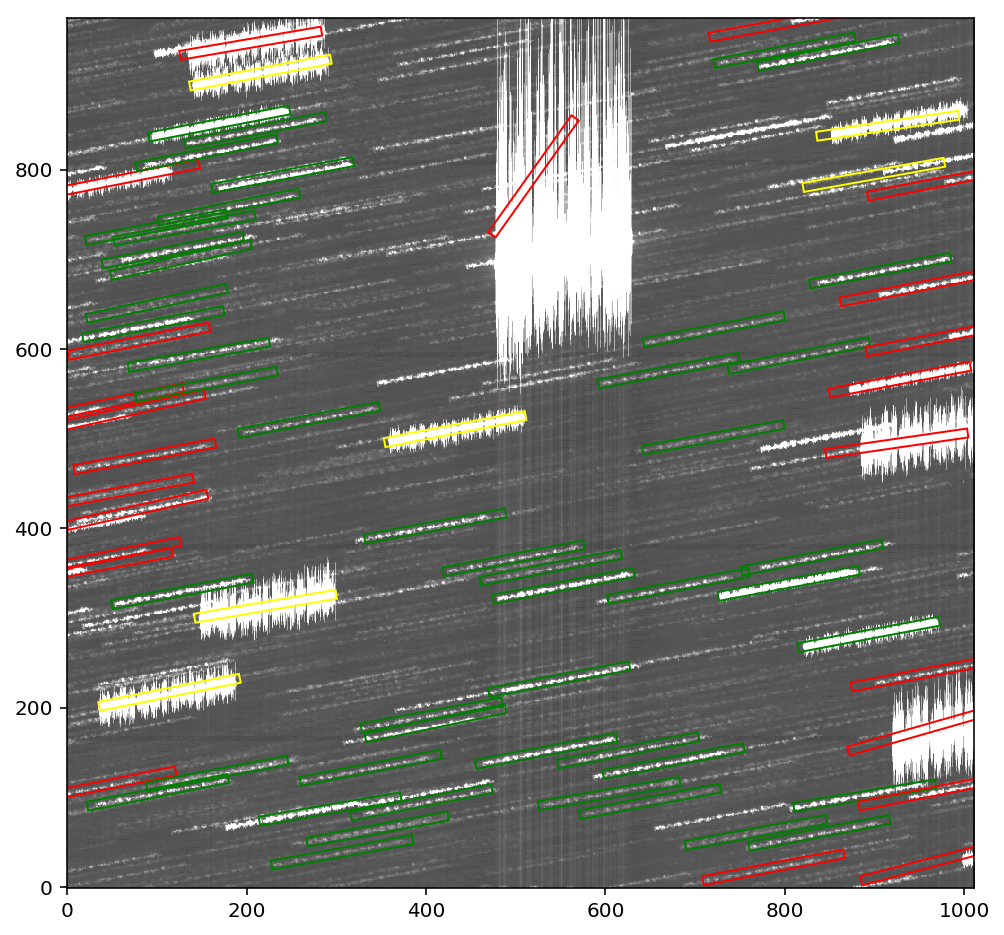

In [32]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    if poor_fits[i]:
        color = 'red'
    elif saturated_mask[i]:
        color = 'yellow'
    else:
        color = 'green'
    e = Rectangle(xy=(objects['x'][i]-80, objects['y'][i]-18),
                width=160,
                height=10,
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor(color)
    ax.add_artist(e)

### Make lightcurves for all objects!

First, make a custom aperture mask.

In [33]:
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve

In [34]:
aper_mask = gaussian_filter(final_kernel, 10)
aper_mask = aper_mask / np.max(aper_mask)

In [35]:
boxcar = np.ones((15,15))

aper_mask = convolve(kernel_mask,boxcar, mode='same')
aper_mask = aper_mask >0.01

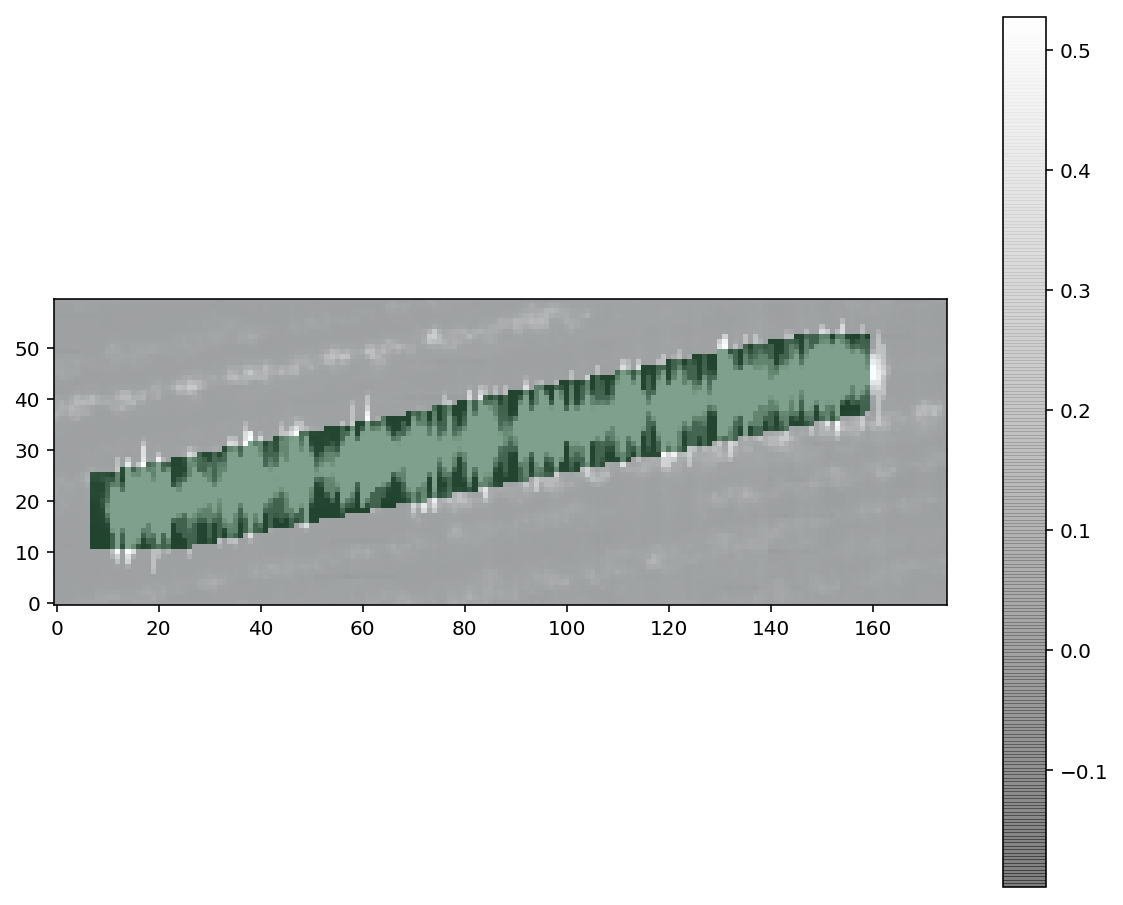

In [36]:
# show the image
m, s = np.mean(kernel_raw), np.std(kernel_raw)
plt.imshow(aper_mask, interpolation='nearest', cmap='BuGn', vmin=0, vmax=1, origin='lower')
plt.imshow(kernel_raw, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower', alpha=0.5)
plt.colorbar();

In [37]:
faint_objects = objects[~poor_fits & ~saturated_mask]

In [38]:
n_faint = len(faint_objects)

In [39]:
faint_lcs = np.zeros((nx, n_faint))

i = 36 is a great source!!!  
44 is solid

In [40]:
for i in range(n_faint):
    x0 = np.int(faint_objects['x'][i]- nx//2)
    y0 = np.int(faint_objects['y'][i]- ny//2)


    ffi_cutout = data_sub[y0:y0+ny, x0:x0+nx]

    # Compute the custom mask.
    boxcar = np.ones((15,15)) #TODO, this number could change based on S/N...
    aper_mask = convolve(kernel_mask,boxcar, mode='same')
    aper_mask = aper_mask >0.01
    custom_mask = aper_mask

    # Here's code to turn on additional local background subtraction.  
    # I don't think we need it...

    #bg_per_pixel = np.percentile(ffi_cutout[~custom_mask], 5)
    #n_pix_in_mask = np.sum(custom_mask, axis=0)
    #total_bg_pixels = bg_per_pixel * n_pix_in_mask
    
    # Here's code to plot the FFI cutout.  Disabled by default...
    #m, s = np.mean(ffi_cutout), np.std(ffi_cutout)
    #plt.imshow(aper_mask, interpolation='nearest', cmap='BuGn', vmin=0, vmax=1, origin='lower')
    #plt.imshow(ffi_cutout, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower', alpha=0.3)
    #plt.colorbar();
    
    faint_lcs[:, i] = np.sum(ffi_cutout * custom_mask, axis=0)

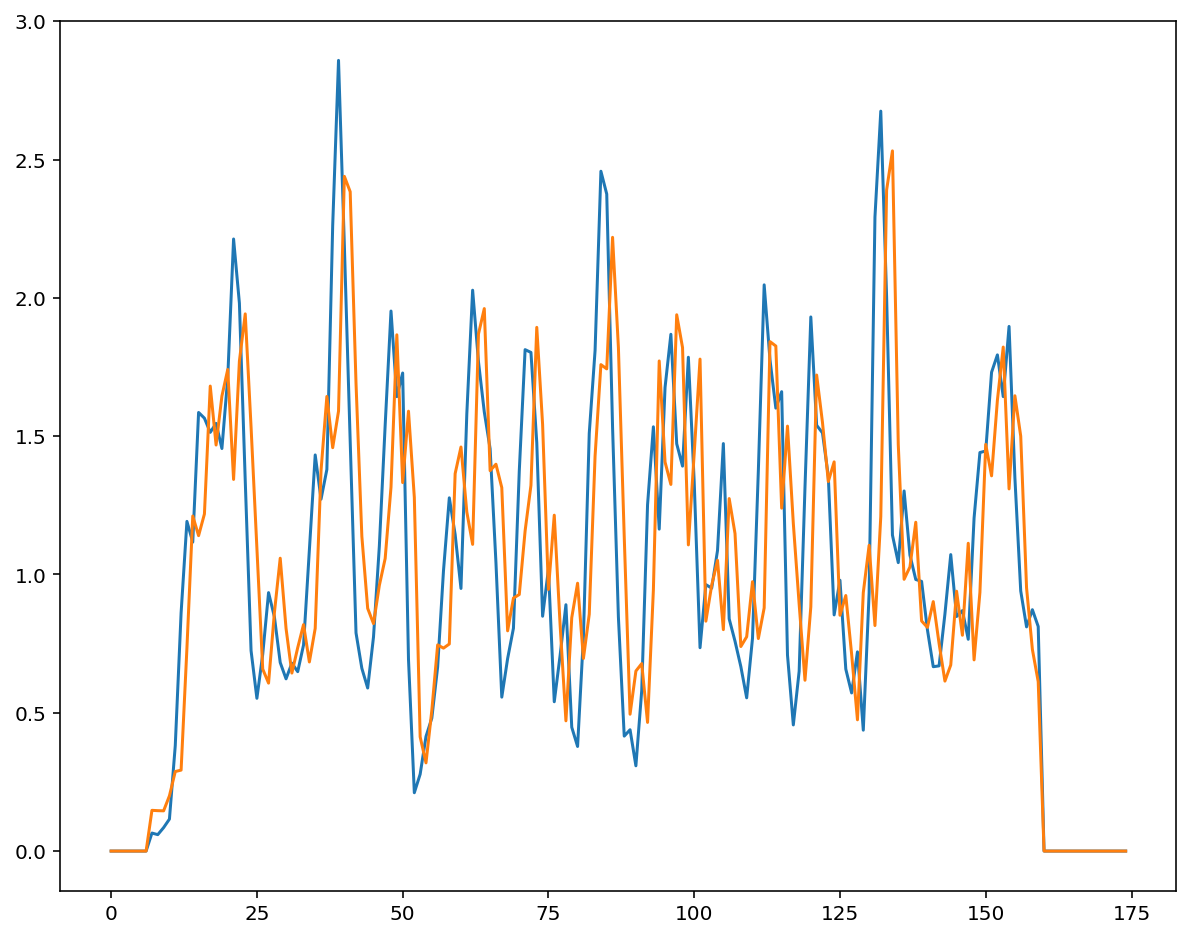

In [41]:
line1 = faint_lcs[:, 44] / np.mean(faint_lcs[:, 44])
rescale = np.mean(faint_lcs[:, i])
line2 = faint_lcs[:, i]  / rescale
plt.plot(line1);
plt.plot(line2);
#plt.plot(line2 - total_bg_pixels / rescale);

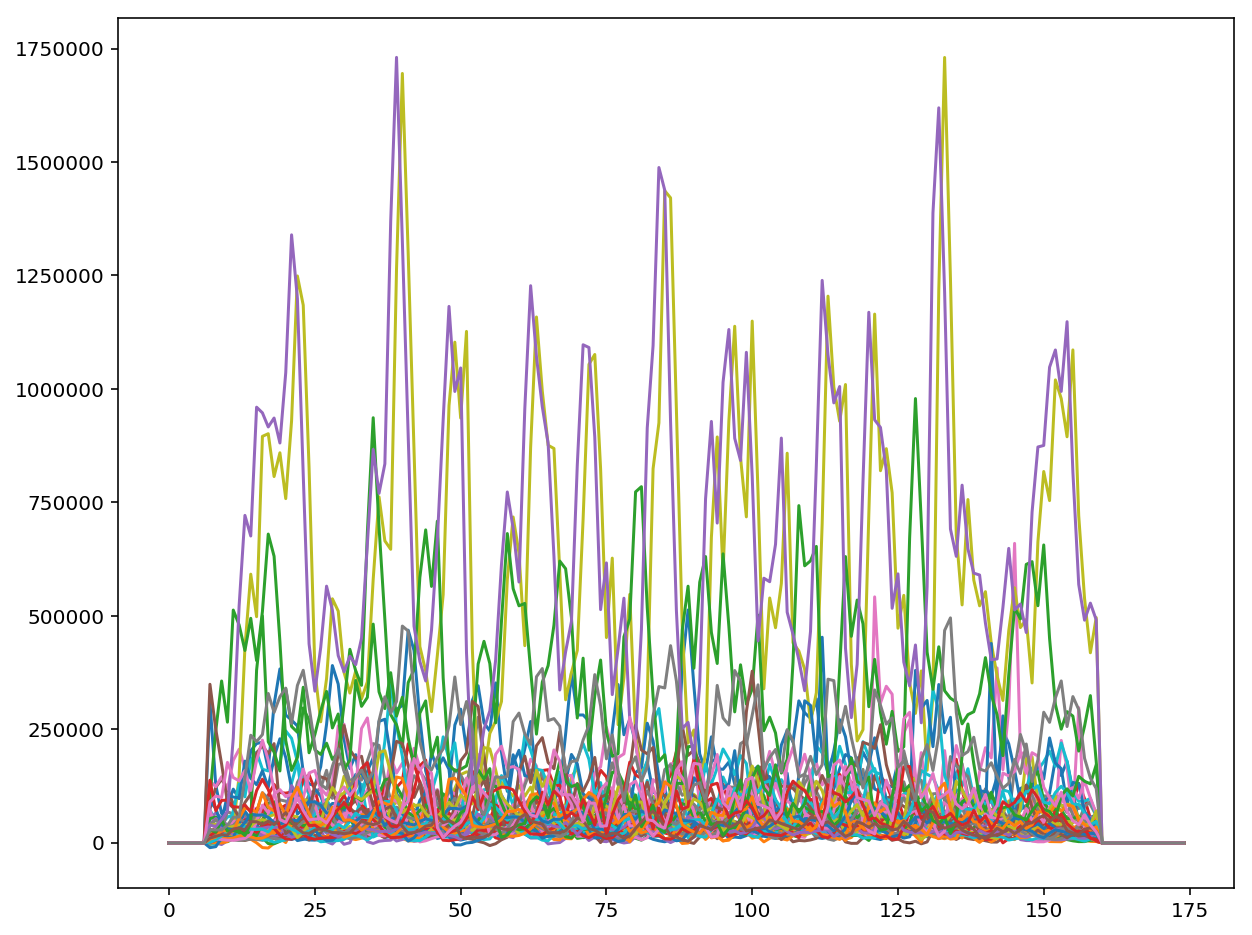

In [42]:
plt.plot(faint_lcs, alpha=1);

Hmmm... It looks like we have minute shifts in the $x$ position.  We also see that the highest signal to noise sources have common structures (as we anticipated from the visual inspection of the lightcurves).  We can refine the coarse $x$ position by picking a high-signal-to-noise-ratio template and cross-correlating it with each other lightcurve to determine a $\delta_x$.  Before we get too far, let's make a dataframe to make these objects easier to work with.

In [43]:
import pandas as pd

In [44]:
faint_df = pd.DataFrame({'coarse_x':faint_objects['x'],
                         'coarse_y':faint_objects['y']})

In [45]:
faint_df['coarse_mean'], faint_df['coarse_std'] = faint_lcs.mean(axis=0), faint_lcs.std(axis=0)

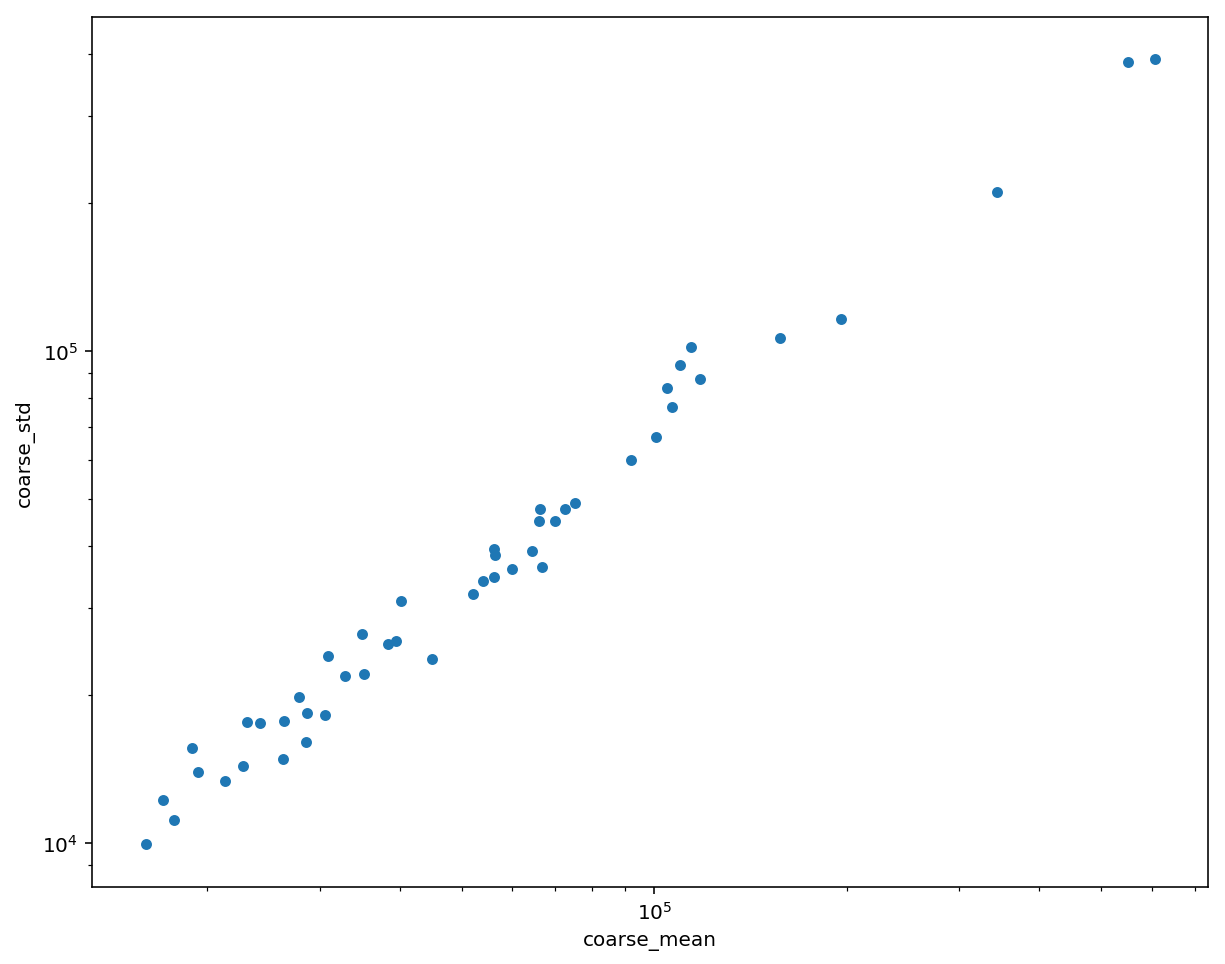

In [46]:
faint_df.plot('coarse_mean', 'coarse_std', kind='scatter', logx=True, logy=True)

It seeems like the spacecraft motion dominates the variance across a wide swath of source intensities.  We'll pick the source with the largest mean.

In [47]:
from scipy.signal import correlate

In [48]:
template_id = faint_df.coarse_mean.idxmax()

In [49]:
template_lc = faint_lcs[:, template_id]

In [50]:
non_zero = template_lc > 0

In [51]:
xcor = correlate(template_lc[non_zero], template_lc[non_zero], 'same')
default_center = np.argmax(xcor)

In [52]:
delta_xs = []

In [53]:
for i in range(n_faint):
    xcor = correlate(template_lc[non_zero], faint_lcs[non_zero, i], 'same')
    center = np.argmax(xcor) - default_center
    delta_xs.append(center)

In [54]:
faint_df['delta_x'] = np.array(delta_xs)

In [55]:
x_vec = np.arange(0, nx)

In [56]:
faint_df.coarse_mean.argsort().values

array([ 0, 29,  1,  5,  4, 27, 33, 30, 21, 34, 31,  2,  3,  6, 45, 11, 14,
       24, 28, 12, 23, 25, 40, 37, 32, 26, 41, 39, 15,  8,  9, 36,  7, 43,
       38, 13, 17, 46, 35, 19, 16, 42, 20, 10, 47, 22, 18, 44])

We need to convert pixel position (x) to time in minutes.

In [57]:
minutes_per_pixel = 29.4 /152.0

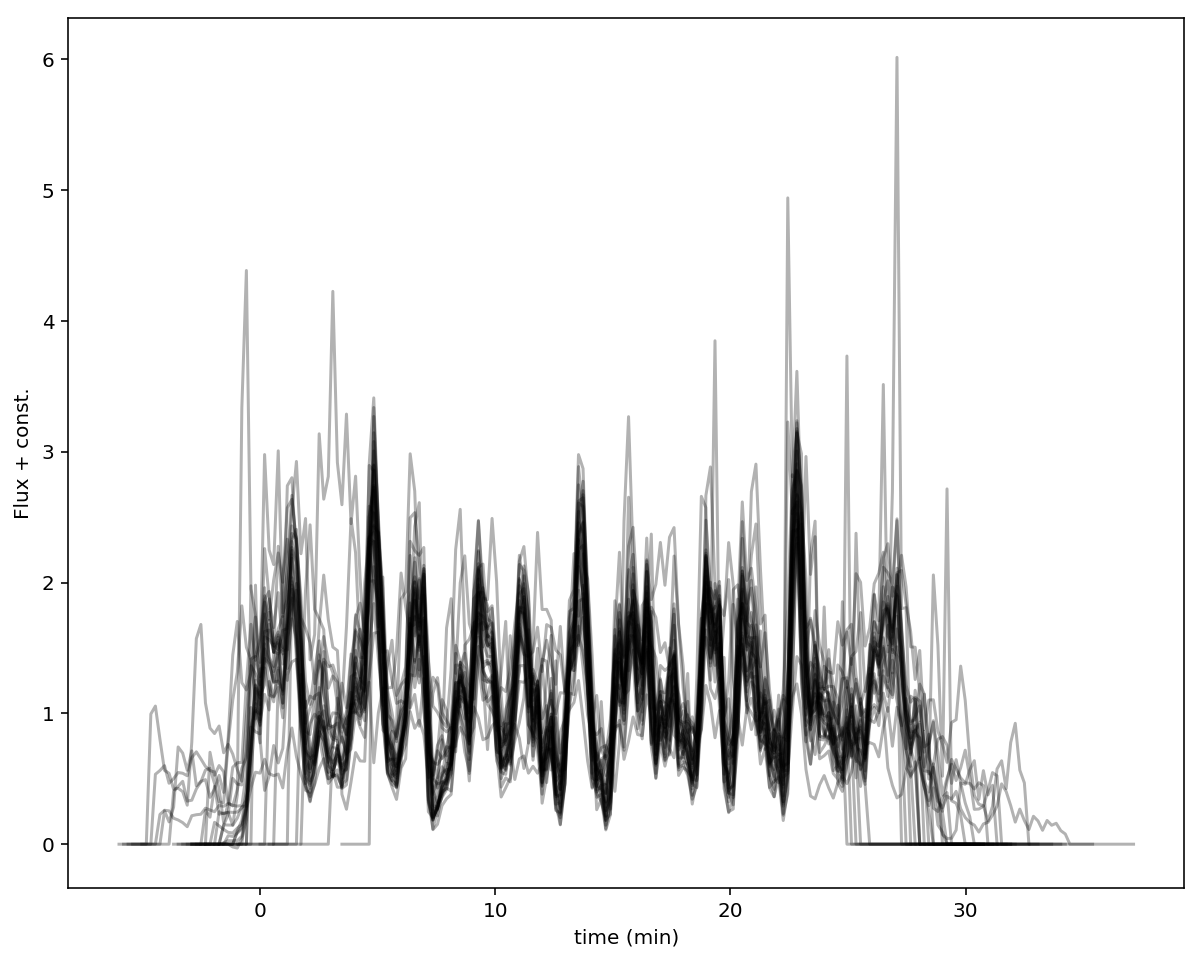

In [59]:
#for i in range(n_faint):
rank = 0
for i in faint_df.coarse_mean.argsort().values:
    corrected_x = x_vec + faint_df.delta_x[i] - 14
    time_vec = corrected_x * minutes_per_pixel
    if faint_df.coarse_mean[i] > 40000:
        plt.plot(time_vec, faint_lcs[:, i]/faint_df.coarse_mean[i] + 0, 'k-', alpha=0.3);
    rank += 1
    
plt.xlabel('time (min)')
plt.ylabel('Flux + const.');

In [60]:
(faint_df.coarse_mean > 40000).sum()

27